In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

import matplotlib.pyplot as plt
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
%matplotlib inline


## Loading Data

In [2]:
data = pd.read_csv('data.csv')

# Data Exploration and Cleaning 

Check&nbsp;how&nbsp;many&nbsp;examples&nbsp;and&nbsp;how&nbsp;many&nbsp;features&nbsp;are&nbsp;in&nbsp;the&nbsp;dataset and counting the number of missing value. replacing all nan var with mean(after checking a few options)

In [3]:
print(data.shape)

(8523, 12)


In [4]:
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


We&nbsp;have&nbsp;8523 examples&nbsp;and&nbsp;11 columns&nbsp;(10&nbsp;features&nbsp;and&nbsp;one&nbsp;label). 

Rename columns to lower letters

In [5]:
data = data.rename(columns=str.lower)
data.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales'],
      dtype='object')

Removing The 'outlet_identifier' column since we didn't see any correlation indicator with the target 'Item_Outlet_Sales', after we executed the pipeline.

In [6]:
data.drop(['outlet_identifier'], axis='columns', inplace=True) 

 If you look at the Item_Identifier. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So we haved used the Item_Identifier variable to create a new column named 'item_type_identifier'

In [7]:
#change column name 
data.rename(columns={'item_identifier': 'item_type_identifier'}, inplace=True)

#Changing the values in the column to the first two letter
data['item_type_identifier'].replace(regex={r'FD...':'Food', 'DR...':'Drinks', 'NC...':'Non-Consumable'}, inplace=True)

In [8]:
data.head()

,item_type_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,Food,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,Drinks,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,Food,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,Food,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,Non-Consumable,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


Lets see the number of unique values of every feature

In [9]:
feature_columns = list(data.columns)
feature_columns.remove('item_outlet_sales')
feature_col_unique_values = {}
for feature in feature_columns:
    feature_col_unique_values[feature] = pd.unique(data[feature]).shape[0]

print(feature_col_unique_values)

{'item_type_identifier': 3, 'item_weight': 416, 'item_fat_content': 5, 'item_visibility': 7880, 'item_type': 16, 'item_mrp': 5938, 'outlet_establishment_year': 9, 'outlet_size': 4, 'outlet_location_type': 3, 'outlet_type': 4}


Lets observe the values of the features, that have less then 20 different values

In [10]:
column_names = feature_col_unique_values.keys()
print(column_names)
for column in column_names:
    if feature_col_unique_values[column] < 20:
        print(column + " :" + str(pd.unique(data[column])))
        print()

dict_keys(['item_type_identifier', 'item_weight', 'item_fat_content', 'item_visibility', 'item_type', 'item_mrp', 'outlet_establishment_year', 'outlet_size', 'outlet_location_type', 'outlet_type'])
item_type_identifier :['Food' 'Drinks' 'Non-Consumable']

item_fat_content :['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

item_type :['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

outlet_establishment_year :[1999 2009 1998 1987 1985 2002 2007 1997 2004]

outlet_size :['Medium' nan 'High' 'Small']

outlet_location_type :['Tier 1' 'Tier 3' 'Tier 2']

outlet_type :['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In Addition , we can see some irregular data collected in the 'item_visibility' column

In [11]:
print('Number of items that have item_visibility == 0  is : '+ str(data.loc[data.item_visibility == 0, 'item_visibility'].count()))

Number of items that have item_visibility == 0  is : 526


Some intersting observations (some of them were seen after we had a working pipeline):

1. In column 'item_fat_content' there are 'Low_Fat' values that have been miss-coded to "LF" OR "low fat". In addition,some of the 'Regular' values are mentioned as 'regular'.

2. There are 16 different types of items 

3. There are 3 different outlet sizes : ['Medium', 'High', 'Small']

4. There are 4 different outlet types : ['Supermarket Type1' ,'Supermarket Type2', 'Grocery Store',
 'Supermarket Type3']
 
5. There are 16 types of item catagories in our data

6. In the 'outlet_establishment_year' column there are 9 different years. We can change the year to a more logical data.
instead of the outlet_establishment_year we can chage the column to years_establisment_been_working(notice that the data is documented in 2013)

7. We can see that 526 items have visibility of 0 , this is not possible . If an item is in the store it most be visible.




Lets fix the data from the above observations: 

- Deal with values with same meaning in 'item_fat_content' column

- We can change the year to a more logical data.
instead of the 'outlet_establishment_year' we can chage the column to 'years_establisment_been_working'(notice that the data is documanted in 2013)

- Changing all items with visibility 0 to the mean value of visibility in the data, this decision is made after reviewing the preformences with the median value. 

In [12]:
#Deal with values with same meaning in 'item_fat_content' column
data['item_fat_content'] = data['item_fat_content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

# change the year to a more logical data
data['outlet_establishment_year'] = 2013 - data['outlet_establishment_year']
data.rename(columns={'outlet_establishment_year':'years_establisment_been_working'},inplace = True)

#Changing all items with visibility 0 to the mean value of visibility in the data
data['item_visibility'].replace(0, np.nan, inplace=True)
items_visibility_mean = data['item_visibility'].mean(skipna=True)
items_visibility_median = data['item_visibility'].median(skipna=True)
data['item_visibility'].fillna(items_visibility_mean, inplace=True)
#data['item_visibility'].fillna(items_visibility_median, inplace=True)


In [13]:
print('Number of items that have item_visibility == 0  is : '+ str(data.loc[data.item_visibility == 0, 'item_visibility'].count()))
print("item_fat_content : " + str(pd.unique(data['item_fat_content'])))

Number of items that have item_visibility == 0  is : 0
item_fat_content : ['Low Fat' 'Regular']


Lets visualize some of the columns values appearances : 

1.'outlet_size' - how many appearances for each size

Text(0.5, 0, 'Appearance')

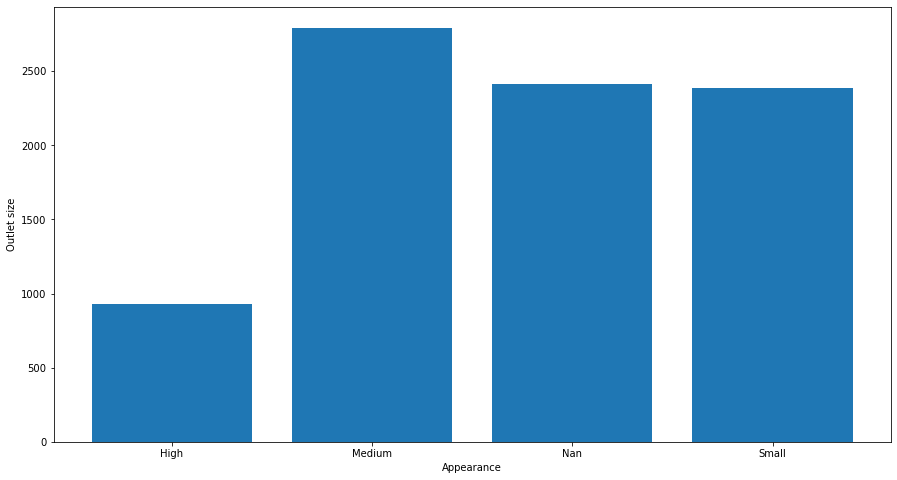

In [14]:

outlet_sizes, outlet_sizes_count = np.unique(data['outlet_size'].fillna('Nan'), return_counts=True)
plt.figure(figsize=(15,8))
plt.bar(outlet_sizes, height=outlet_sizes_count)
plt.ylabel('Outlet size')
plt.xlabel('Appearance')


2.'item_type' - how many appearances for each item type

Text(0.5, 0, 'Appearance')

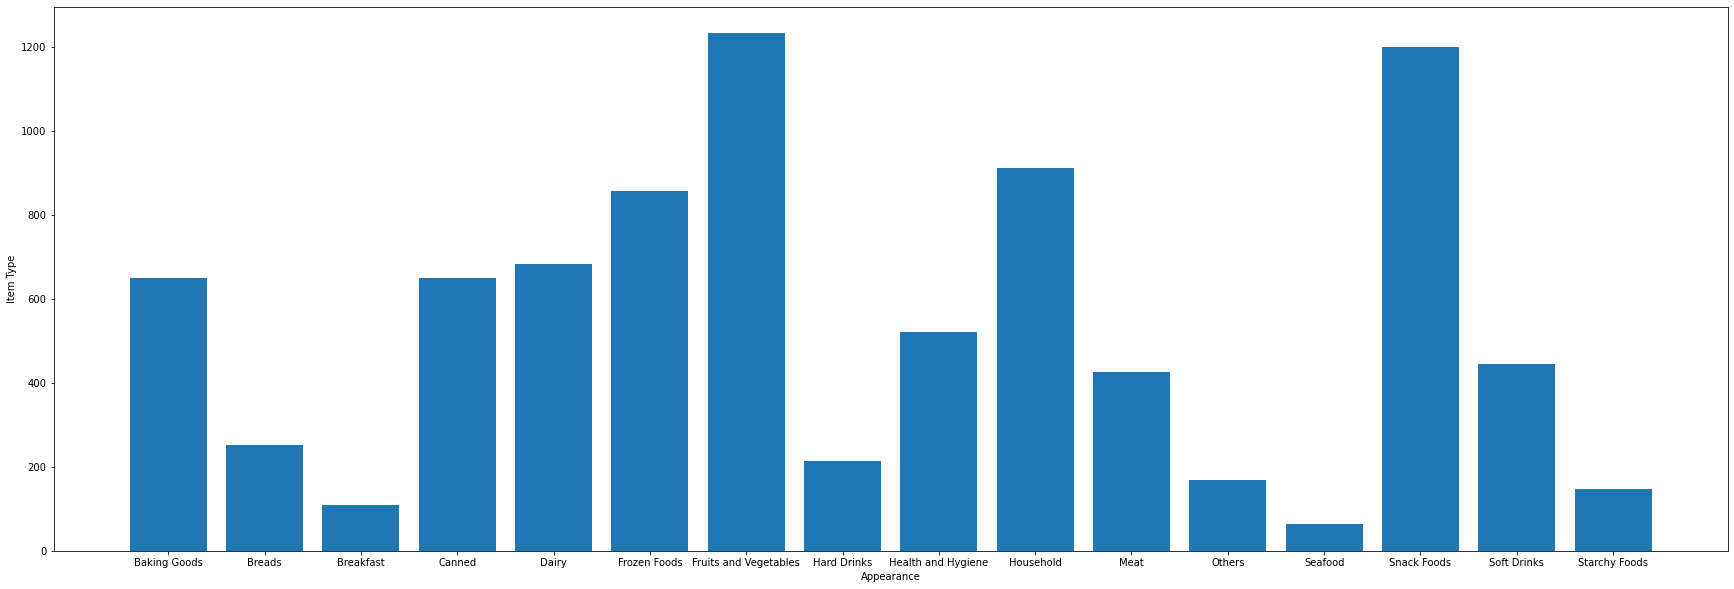

In [15]:
#Option is to change small count values to other type of foods 
item_types,item_type_count = np.unique(data['item_type'],return_counts=True)
plt.figure(figsize=(30,10))
plt.bar(item_types, height=item_type_count)
plt.ylabel('Item Type')
plt.xlabel('Appearance')

Lets visualize the distribiution of the item sales given the outlet type

\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='outlet_type', ylabel='item_outlet_sales'>

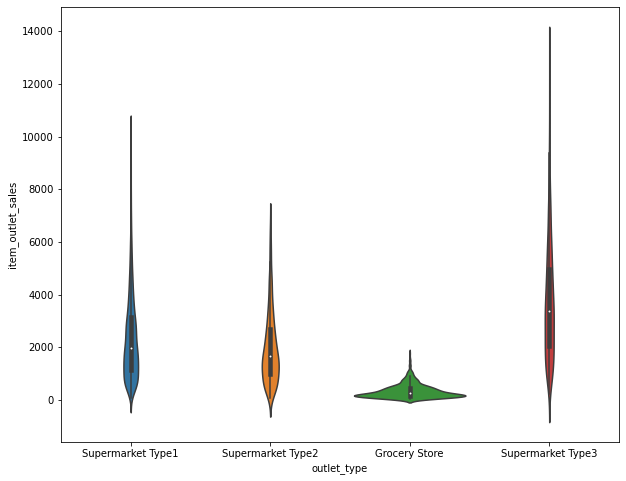

In [16]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.violinplot('outlet_type','item_outlet_sales', ax=ax, data = data)

From the figure above we can conclude that grocery stores has the most of the lower price sales as compared to other store types. 
From this visualizaion we can consider marging the Type 1 and type 2 Supermarkets, 
lets see the mean of sales given the supermarket type

In [17]:
data.pivot_table(values='item_outlet_sales',index='outlet_type')


,item_outlet_sales
outlet_type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


We can see that the diffrence between Type 1 and Type 2 are more significate then the visualization. 
Therfore we won`t combine this feature values.  

## Labels\Amount of Sales Distribution

Following is a Histogram of the number of sales distribution:


Text(0.5, 0, 'Sales Bins')

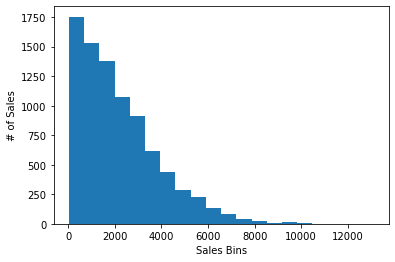

In [18]:
print("Following is a Histogram of the number of sales distribution:")
plt.hist(data['item_outlet_sales'], bins=20)
plt.ylabel('# of Sales')
plt.xlabel('Sales Bins')

We can see that the majority of the products were sold 0 - 3000 times and that some products sold more than 3000 times.

checking which columns have Nan values 

In [19]:
data.isna().mean()

item_type_identifier               0.000000
item_weight                        0.171653
item_fat_content                   0.000000
item_visibility                    0.000000
item_type                          0.000000
item_mrp                           0.000000
years_establisment_been_working    0.000000
outlet_size                        0.282764
outlet_location_type               0.000000
outlet_type                        0.000000
item_outlet_sales                  0.000000
dtype: float64

We see that we have two columns that have missing values. 

1.item_weight - approximately 17% of the data                        

2.outlet_size - approximatley 28% of the data 

After evaluating the data set we decided to fill the Nan values in the 'outlet_size' column with the majority size of that instance outlet_type

In [20]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='outlet_size', columns='outlet_type',aggfunc=(lambda x:mode(x).mode[0]) )
print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['outlet_size'].isnull() 



#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d \n'% sum(miss_bool))
data.loc[miss_bool,'outlet_size'] = data.loc[miss_bool,'outlet_type'].apply(lambda x: outlet_size_mode[x])
print ('\nChanged #missing: %d \n'%sum(data['outlet_size'].isnull()))



Mode for each Outlet_Type:
outlet_type Grocery Store Supermarket Type1 Supermarket Type2  \
outlet_size         Small             Small            Medium   

outlet_type Supermarket Type3  
outlet_size            Medium  

Orignal #missing: 2410 


Changed #missing: 0 



In [21]:
data.isna().mean()

item_type_identifier               0.000000
item_weight                        0.171653
item_fat_content                   0.000000
item_visibility                    0.000000
item_type                          0.000000
item_mrp                           0.000000
years_establisment_been_working    0.000000
outlet_size                        0.000000
outlet_location_type               0.000000
outlet_type                        0.000000
item_outlet_sales                  0.000000
dtype: float64

We noticed that some columns contains Categorial data. So in order to run regressor we covert these columns to 'one-hot' columns and add them to the data.

In [22]:
#delete box - this is for quick running of the pipline 
columns_list_for_get_dummies = ['item_type_identifier','item_fat_content' , 'item_type' , 'outlet_size' ,'outlet_location_type' , 'outlet_type' ]
dummy_data = pd.get_dummies(data, columns=columns_list_for_get_dummies)

In [23]:
dummy_data.head(10)

,item_weight,item_visibility,item_mrp,years_establisment_been_working,item_outlet_sales,item_type_identifier_Drinks,item_type_identifier_Food,item_type_identifier_Non-Consumable,item_fat_content_Low Fat,item_fat_content_Regular,...,outlet_size_High,outlet_size_Medium,outlet_size_Small,outlet_location_type_Tier 1,outlet_location_type_Tier 2,outlet_location_type_Tier 3,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
0,9.300,0.016047,249.8092,14,3735.1380,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
1,5.920,0.019278,48.2692,4,443.4228,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
2,17.500,0.016760,141.6180,14,2097.2700,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
3,19.200,0.070482,182.0950,15,732.3800,0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
4,8.930,0.070482,53.8614,26,994.7052,0,0,1,1,0,...,1,0,0,0,0,1,0,1,0,0
5,10.395,0.070482,51.4008,4,556.6088,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
6,13.650,0.012741,57.6588,26,343.5528,0,1,0,0,1,...,1,0,0,0,0,1,0,1,0,0
7,NaN,0.127470,107.7622,28,4022.7636,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
8,16.200,0.016687,96.9726,11,1076.5986,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
9,19.200,0.094450,187.8214,6,4710.5350,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0


lets see the correlations of the attributes with the target market sales

Text(0.5, 1.0, 'Correlations')

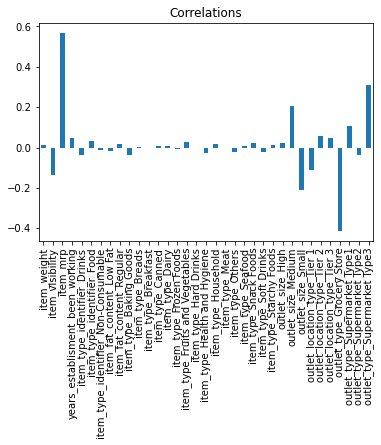

In [24]:

# Plot the corralation matrix without the Traget Value
# data.corr()['item_outlet_sales'].drop('item_outlet_sales').plot.bar()
dummy_data.corr()['item_outlet_sales'].drop('item_outlet_sales').plot.bar()
plt.title('Correlations')

# Train and test split

Split to train and test sets:

In [25]:
features_to_drop_by_lasso = ['item_type_identifier_Drinks',
       'item_type_identifier_Food', 'item_type_identifier_Non-Consumable',
       'item_fat_content_Low Fat', 'item_fat_content_Regular',
       'item_type_Baking Goods', 'item_type_Breads', 'item_type_Breakfast',
       'item_type_Canned', 'item_type_Dairy', 'item_type_Frozen Foods',
       'item_type_Fruits and Vegetables', 'item_type_Hard Drinks',
       'item_type_Health and Hygiene', 'item_type_Household', 'item_type_Meat',
       'item_type_Others', 'item_type_Seafood', 'item_type_Snack Foods',
       'item_type_Soft Drinks', 'item_type_Starchy Foods', 'outlet_size_High',
       'outlet_size_Medium', 'outlet_size_Small',
       'outlet_location_type_Tier 1', 'outlet_location_type_Tier 2',
       'outlet_location_type_Tier 3',]
X, y = dummy_data.drop('item_outlet_sales', axis=1), dummy_data.item_outlet_sales
train_test_ratio = 0.25
X = X.drop(features_to_drop_by_lasso , axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_ratio, random_state=0, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6392, 8), (6392,), (2131, 8), (2131,))

seeing the avg weigth given the item type

In [26]:
item_avg_weight = data.pivot_table(values='item_weight', index='item_type',dropna=True)
print(item_avg_weight)


                       item_weight
item_type                         
Baking Goods             12.277108
Breads                   11.346936
Breakfast                12.768202
Canned                   12.305705
Dairy                    13.426069
Frozen Foods             12.867061
Fruits and Vegetables    13.224769
Hard Drinks              11.400328
Health and Hygiene       13.142314
Household                13.384736
Meat                     12.817344
Others                   13.853285
Seafood                  12.552843
Snack Foods              12.987880
Soft Drinks              11.847460
Starchy Foods            13.690731


From the following cell and the table above we can see that the average weight of a product is around the average weight of any other product type:

In [27]:
np.mean(data['item_weight'])

12.857645184135976

We will use this as an assumption and impute the missing values using the mean value.

# Imputation

In [28]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

In [29]:
X_train_imputed.isna().mean()

item_weight                        0.0
item_visibility                    0.0
item_mrp                           0.0
years_establisment_been_working    0.0
outlet_type_Grocery Store          0.0
outlet_type_Supermarket Type1      0.0
outlet_type_Supermarket Type2      0.0
outlet_type_Supermarket Type3      0.0
dtype: float64

We don't have any missing values anymore. We can move on to prepare the Data for learning.

# Pipeline

# Evaluation Function

In [30]:
def check_regressor(regressor, X_train, y_train, X_test, y_test):
    # Fit regression model
    regressor.fit(X_train, y_train)

    # Predict
    y_pred = regressor.predict(X_test)
    
    model_name = regressor.__class__.__name__
    mse = mean_squared_error(y_test, y_pred, squared=False)
    
    y_pred_train = regressor.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train, squared=False)

    print(f'{model_name} test RMSE is {mse:.4f}, train RMSE is {mse_train:.4f}')
    return model_name, mse

models_errors = {}

# Baseline

In [31]:
class ConstantBaseline:
    '''
    Predicts for every instance the mean value of the labels.
    '''
    def __init__(self, value):
        self.y_pred = value
    
    def fit(self, x, y):
        return self
    
    def predict(self, x):
        return np.ones(len(x)) * self.y_pred

baseline = ConstantBaseline(y_train.mean())
name, mse = check_regressor(baseline, X_train, y_train, X_test, y_test)
models_errors[name] = mse

ConstantBaseline test RMSE is 1730.9446, train RMSE is 1698.1390


In [32]:
def best_pair(k_evaluations):
    '''
    Returns the k and it's value that has the lowest evaluation value.
    parameters:
    k_evaluations    a Dictionary of k:erros pairs
    Returns:
    k                a number
    '''
    min_value = min(k_evaluations.values())
    for k in k_evaluations.keys():
        if k_evaluations[k] == min_value:
            return k, k_evaluations[k]

# Nearest Neighbors Regressor

In [33]:
k_list = [4, 7, 11]
k_evaluations = {}

for k in k_list:
    nearest_neighbors = KNeighborsRegressor(k)
    name, mse = check_regressor(nearest_neighbors, X_train_imputed, y_train, X_test_imputed, y_test)
    k_evaluations[k] = mse

best_k, value = best_pair(k_evaluations)

print(f"The best K is {best_k} and The test evaluation value is {value}")

models_errors[name] = value

KNeighborsRegressor test RMSE is 1349.5699, train RMSE is 1003.3687
KNeighborsRegressor test RMSE is 1326.7003, train RMSE is 1096.8098
KNeighborsRegressor test RMSE is 1347.3461, train RMSE is 1175.4304
The best K is 7 and The test evaluation value is 1326.7003229786337


# KNN Scaled

In [34]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(X_train_imputed)
X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

k_list = [ 3 , 7 , 9 ]
k_evaluations = {}

for k in k_list:
    nearest_neighbors = KNeighborsRegressor(k)
    name, mse = check_regressor(nearest_neighbors, X_train_scaled, y_train, X_test_scaled, y_test)
    k_evaluations[k] = mse

best_k, value = best_pair(k_evaluations)

print(f"The best K is {best_k} and The test evaluation value is {value}")

models_errors[name + ' (Scaled)'] = value

KNeighborsRegressor test RMSE is 1236.5555, train RMSE is 873.0028
KNeighborsRegressor test RMSE is 1172.9447, train RMSE is 989.0287
KNeighborsRegressor test RMSE is 1156.3218, train RMSE is 1004.2267
The best K is 9 and The test evaluation value is 1156.3217921671453


In [35]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).describe()

,item_weight,item_visibility,item_mrp,years_establisment_been_working,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
count,6.392000e+03,6.392000e+03,6.392000e+03,6.392000e+03,6.392000e+03,6.392000e+03,6.392000e+03,6.392000e+03
mean,-1.861951e-17,1.678535e-16,2.806822e-16,3.334838e-17,-4.001805e-17,1.056032e-17,-5.002256e-18,-3.334838e-18
std,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00
min,-1.975820e+00,-1.371766e+00,-1.741636e+00,-1.333665e+00,-3.803934e-01,-1.375612e+00,-3.509657e-01,-3.509657e-01
25%,-8.318028e-01,-7.665902e-01,-7.594282e-01,-7.359796e-01,-3.803934e-01,-1.375612e+00,-3.509657e-01,-3.509657e-01
50%,0.000000e+00,-1.564110e-01,3.093548e-02,-1.382942e-01,-3.803934e-01,7.269493e-01,-3.509657e-01,-3.509657e-01
75%,7.530389e-01,4.880213e-01,7.193988e-01,1.296151e+00,-3.803934e-01,7.269493e-01,-3.509657e-01,-3.509657e-01
max,1.993966e+00,5.296026e+00,2.024325e+00,1.535225e+00,2.628857e+00,7.269493e-01,2.849281e+00,2.849281e+00


# Decision Tree Regressor

In [36]:
max_depth_list = [2,6,9]
max_depth_evaluations = {}

for max_depth in max_depth_list:
    decision_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
    # name, mse = check_regressor(decision_tree, X_train_scaled, y_train, X_test_scaled, y_test)
    name, mse = check_regressor(decision_tree, X_train_imputed, y_train, X_test_imputed, y_test)
    max_depth_evaluations[max_depth] = mse

best_max_depth, value = best_pair(max_depth_evaluations)
print(f"The best max depth  is {best_max_depth} and The test evaluation value is {value}")
models_errors[name] = value

DecisionTreeRegressor test RMSE is 1300.1533, train RMSE is 1280.2745
DecisionTreeRegressor test RMSE is 1113.5723, train RMSE is 1052.5388
DecisionTreeRegressor test RMSE is 1185.8530, train RMSE is 982.9031
The best max depth  is 6 and The test evaluation value is 1113.5722868612604


# Random Forest Regressor

In [37]:
n_estimators = 100
max_depth_list = [2,6,9]
max_depth_evaluations = {}

for max_depth in max_depth_list:
    random_forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    name, mse = check_regressor(random_forest, X_train_imputed, y_train, X_test_imputed, y_test)
    max_depth_evaluations[max_depth] = mse

best_max_depth, value = best_pair(max_depth_evaluations)

print(f"The best max depth  is {best_max_depth} and The test evaluation value is {value}")

models_errors[name] = value

RandomForestRegressor test RMSE is 1277.3941, train RMSE is 1235.4663
RandomForestRegressor test RMSE is 1102.8548, train RMSE is 1040.1441
RandomForestRegressor test RMSE is 1113.0574, train RMSE is 947.9122
The best max depth  is 6 and The test evaluation value is 1102.854845676016


<AxesSubplot:>

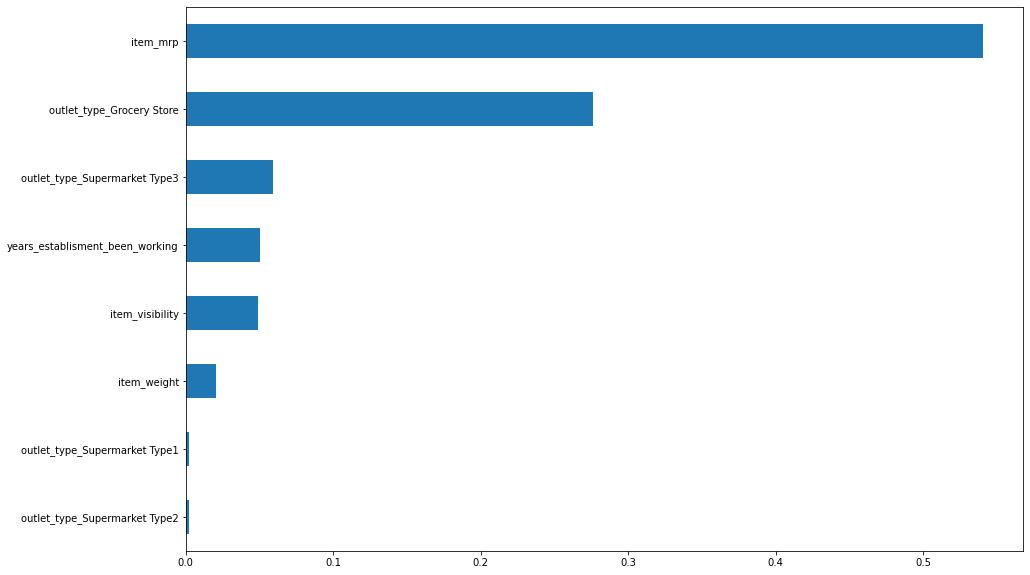

In [38]:
feature_importence = pd.Series(random_forest.feature_importances_, index=X_train.columns).sort_values()
feature_importence.plot(kind='barh',figsize=(15,10))


In [39]:
print(pd.Series(random_forest.feature_importances_, index=X_train.columns).sort_values())

outlet_type_Supermarket Type2      0.001960
outlet_type_Supermarket Type1      0.002172
item_weight                        0.020637
item_visibility                    0.048753
years_establisment_been_working    0.050351
outlet_type_Supermarket Type3      0.059269
outlet_type_Grocery Store          0.276392
item_mrp                           0.540466
dtype: float64


# AdaBoost Regressor

In [40]:
n_estimators = 100

max_depth_list = [3,7,11]
max_depth_evaluations = {}

for max_depth in max_depth_list:
    tree = DecisionTreeRegressor(max_depth=max_depth)
    ada_boost = AdaBoostRegressor(tree, n_estimators=n_estimators, random_state=0)
    name, mse = check_regressor(ada_boost, X_train_imputed, y_train, X_test_imputed, y_test)
    max_depth_evaluations[max_depth] = mse

best_max_depth, value = best_pair(max_depth_evaluations)
print(f"The best max depth  is {best_max_depth} and The test evaluation value is {value}")
models_errors[name] = value

AdaBoostRegressor test RMSE is 1248.0718, train RMSE is 1214.6134
AdaBoostRegressor test RMSE is 1200.9467, train RMSE is 1032.7560
AdaBoostRegressor test RMSE is 1157.8170, train RMSE is 667.3475
The best max depth  is 11 and The test evaluation value is 1157.8170470905925


<AxesSubplot:>

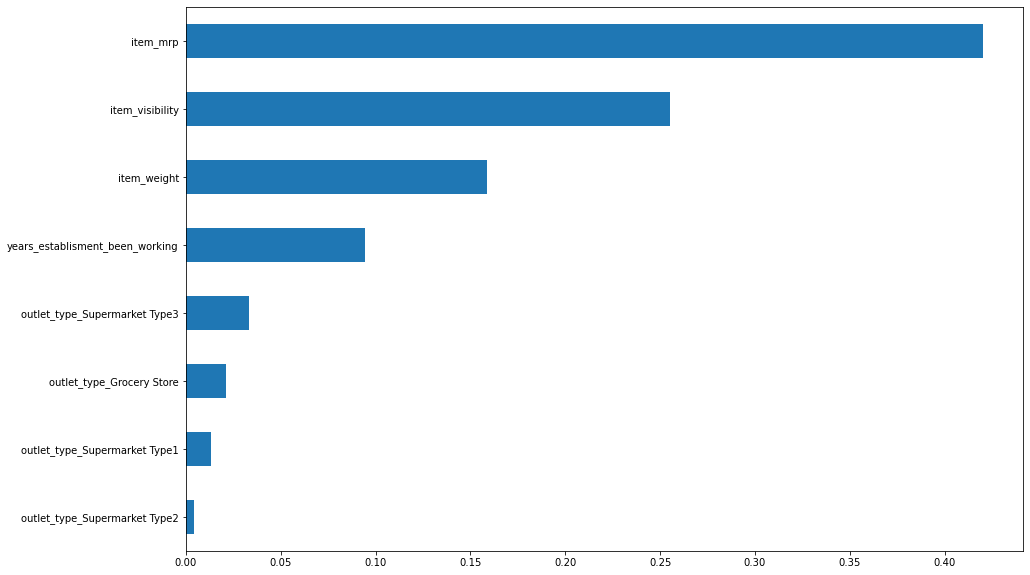

In [41]:
feature_importence = pd.Series(ada_boost.feature_importances_, index=X_train.columns).sort_values()
feature_importence.plot(kind='barh',figsize=(15,10))

# Linear Regressor

In [42]:
linear_regressor = LinearRegression(normalize=True)
name, mse = check_regressor(linear_regressor, X_train_imputed, y_train, X_test_imputed, y_test)
models_errors[name] = mse

LinearRegression test RMSE is 1147.6734, train RMSE is 1123.1070


<AxesSubplot:>

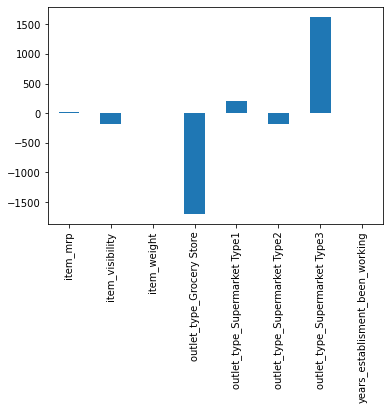

In [43]:
pd.Series(linear_regressor.coef_, index=X.columns).sort_index().plot.bar()

# Lasso Scaled

In [44]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(X_train_imputed)
X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

alpha_list = [0.000001,0.0001 ,0.01 ]
alpha_evaluations = {}

for alpha in alpha_list:
    lasso = Lasso(alpha=alpha)
    name, mse = check_regressor(lasso, X_train_scaled, y_train, X_test_scaled, y_test)
    alpha_evaluations[alpha] = mse

best_alpha, value = best_pair(alpha_evaluations)
print(f"The best alpha  is {best_alpha} and The test evaluation value is {value}")
models_errors[name] = value

Lasso test RMSE is 1147.6734, train RMSE is 1123.1070
Lasso test RMSE is 1147.6734, train RMSE is 1123.1070
Lasso test RMSE is 1147.6712, train RMSE is 1123.1070
The best alpha  is 0.01 and The test evaluation value is 1147.671176969377


<AxesSubplot:>

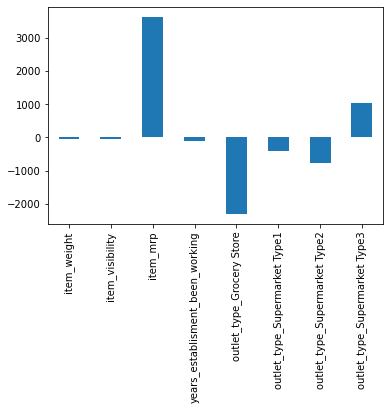

In [45]:
pd.Series(lasso.coef_, index=X.columns).plot.bar()

# Performance Comparison

In [46]:
pd.Series(models_errors, name='mean squared error').sort_values().to_frame()

,mean squared error
RandomForestRegressor,1102.854846
DecisionTreeRegressor,1113.572287
Lasso,1147.671177
LinearRegression,1147.673416
KNeighborsRegressor (Scaled),1156.321792
AdaBoostRegressor,1157.817047
KNeighborsRegressor,1326.700323
ConstantBaseline,1730.944640


# Hyperparameters Search on Random Forest Regressor

In [ ]:
n_estimators_list = [50,75,100,125,150,200,250]
max_depth_list = [1,2,3,4,5,6,7]
pairs = {}
rmse_train_depth6 = [] 
rmse_test_depth6 = [] 

for estimator in n_estimators_list:
    for max_depth in max_depth_list:
        random_forest = RandomForestRegressor(n_estimators=estimator, max_depth=max_depth, random_state=0)
        random_forest.fit(X_train_imputed, y_train)
        y_pred_train = random_forest.predict(X_train_imputed)
        y_pred = random_forest.predict(X_test_imputed)
        rmse_current_train = mean_squared_error(y_train, y_pred_train, squared=False)
        rmse_current_test = mean_squared_error(y_test, y_pred, squared=False)
        pairs[(estimator, max_depth)] = rmse_current_test
        if max_depth == 6 :
            rmse_test_depth6.append(rmse_current_test)
            rmse_train_depth6.append(rmse_current_train)

params, mse_value = best_pair(pairs)
print(params)
print(mse_value)
        

In [ ]:
plt.plot(n_estimators_list, rmse_train_depth6, 'o', color='orange')
plt.plot(n_estimators_list, rmse_test_depth6, 'o', color='blue' )

circle_rad = 15  # This is the radius, in points
# Mark the previous minimal pair (found by searching between 3 values)
plt.plot([150] , min(rmse_test_depth6), 'o', ms=circle_rad * 2, mec='green', mfc='None', mew=2)
plt.text(50, rmse_test_depth6[2] - 10, f'(100,6) --> {rmse_test_depth6[2]:.2f}', c='r')
# Mark the minimal pair (found by grid search)
plt.plot([100] , rmse_test_depth6[2], 'o', ms=circle_rad * 2, mec='r', mfc='None', mew=2)
plt.text(120, min(rmse_test_depth6)- 10, f'(150,6) --> {min(rmse_test_depth6):.2f}', c='green')


plt.legend(["Train","Test"])
plt.title("RMSE as a function of #n_estimators given max_depth = 6")
plt.ylabel("RMSE")
plt.xlabel("n_estimators")

# Performance vs. amount of data

In [ ]:
#df.iloc[[2, 3, 5]]
import random
#[10%/30%/50%/70%/100%] 

estimator = 200
max_depth = 5
ratios_mse = []

X_train_precentege = [0.1,0.3,0.5,0.7,1]

for ratio in X_train_precentege:
    random_lines =random.sample(range(0,len(X_train_imputed)), int(ratio * len(X_train_imputed)))
    # print(random_lines)
    new_X_train = X_train_imputed.iloc[random_lines]
    new_y_train = y_train.iloc[random_lines]
    random_forest = RandomForestRegressor(n_estimators=estimator, max_depth=max_depth, random_state=0)
    random_forest.fit(new_X_train, new_y_train)
    y_pred = random_forest.predict(X_test_imputed)
    ratios_mse.append(mean_squared_error(y_test, y_pred))





In [ ]:
plt.figure(figsize=(10,7))
plt.ylabel('RMSE')
plt.xlabel('Train instances ratio')
plt.title("RMSE as a function of % of samples from the Training Set")
plt.plot(X_train_precentege, ratios_mse)

## Would you recommend collecting more data for the problem?



There is no need to collect more data, as we see in the graph above, after using more than 50% from the training data the RMSE is not decreasing . 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=683d9d6a-22c3-4c97-92ba-d27f27ba00e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>